
[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


C:\Users\Simbo\AppData\Local\Temp\ipykernel_72480\3711302280.py:16: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')


Logistic Regression (Claim Frequency):
Accuracy: 0.9971
Precision: 0.5000
Recall: 0.0017
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    199439
        True       0.50      0.00      0.00       581

    accuracy                           1.00    200020
   macro avg       0.75      0.50      0.50    200020
weighted avg       1.00      1.00      1.00    200020


Random Forest (Claim Frequency):
Accuracy: 0.9970
Precision: 0.0526
Recall: 0.0017
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    199439
        True       0.05      0.00      0.00       581

    accuracy                           1.00    200020
   macro avg       0.52      0.50      0.50    200020
weighted avg       0.99      1.00      1.00    200020



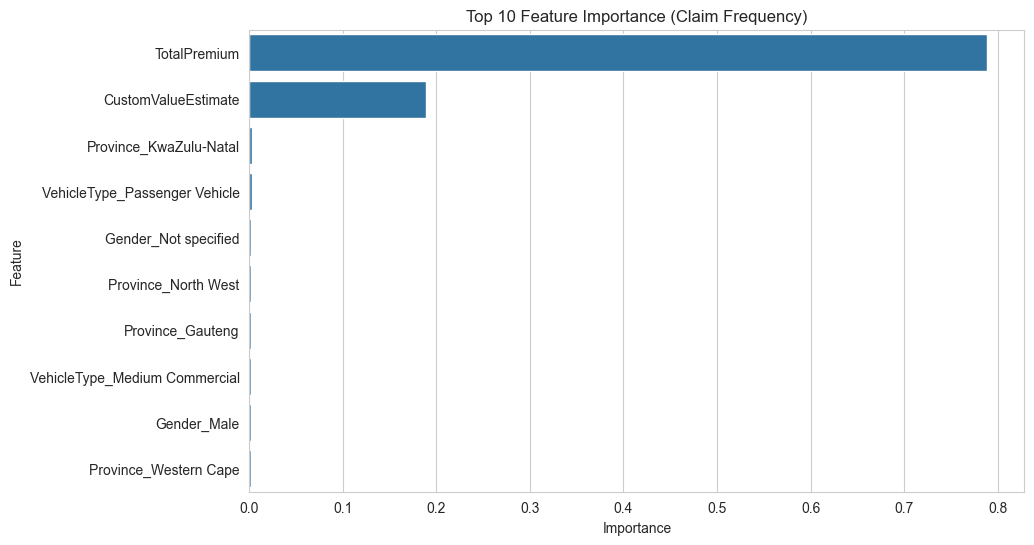


Linear Regression (Claim Severity):
RMSE: 39114.16
R²: 0.0487

Random Forest (Claim Severity):
RMSE: 36280.83
R²: 0.1815


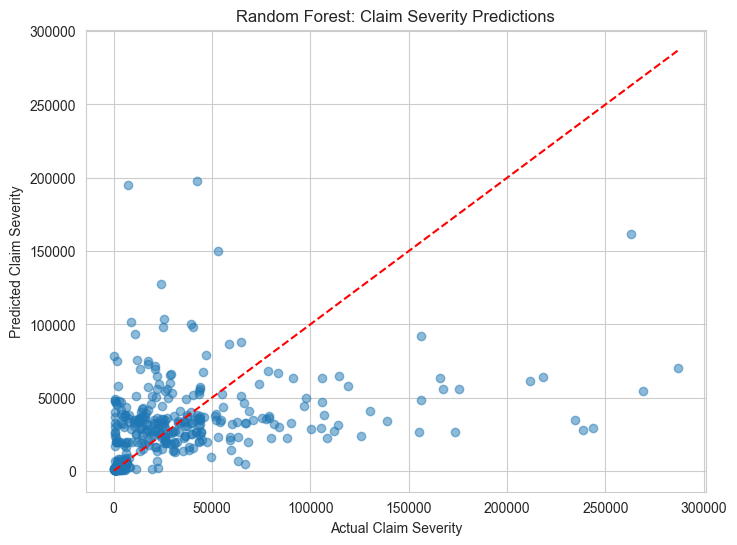


XGBoost (Margin):
RMSE: 2226.03
R²: -0.0218


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, classification_report
%pip install xgboost
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

try:
    # Load data (adjust sep based on inspection)
    df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')
except FileNotFoundError:
    print("Error: MachineLearningRating_v3.txt not found in data/.")
    exit()

# Preprocessing
df['HasClaim'] = df['TotalClaims'] > 0
df['ClaimSeverity'] = df['TotalClaims'].where(df['HasClaim'], np.nan)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Select features and handle missing values
# Remove 'PostalCode' due to high cardinality to avoid MemoryError
features = ['TotalPremium', 'CustomValueEstimate', 'Province', 'Gender', 'VehicleType']
numeric_features = ['TotalPremium', 'CustomValueEstimate']
categorical_features = ['Province', 'Gender', 'VehicleType']

# Encode categorical variables
df_encoded = pd.get_dummies(df[features], columns=categorical_features, drop_first=True)

# Handle missing values
df_encoded[numeric_features] = df_encoded[numeric_features].fillna(df_encoded[numeric_features].mean())

# 1. Logistic Regression: Predict Claim Frequency (HasClaim)
X = df_encoded
y_freq = df['HasClaim'].fillna(False)
X_train, X_test, y_train, y_test = train_test_split(X, y_freq, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_freq = log_reg.predict(X_test)

print("Logistic Regression (Claim Frequency):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_freq):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_freq):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_freq):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_freq))

# 2. Random Forest: Predict Claim Frequency
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf_freq = rf_clf.predict(X_test)

print("\nRandom Forest (Claim Frequency):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_freq):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_freq):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_freq):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf_freq))

# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_clf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 10 Feature Importance (Claim Frequency)')
plt.savefig('../docs/feature_importance_frequency.png')
plt.show()

# 3. Linear Regression: Predict Claim Severity
df_severity = df[df['HasClaim']].copy()
X_severity = pd.get_dummies(df_severity[features], columns=categorical_features, drop_first=True)
X_severity[numeric_features] = X_severity[numeric_features].fillna(X_severity[numeric_features].mean())
y_severity = df_severity['ClaimSeverity'].fillna(df_severity['ClaimSeverity'].mean())

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_sev, y_train_sev)
y_pred_sev = lin_reg.predict(X_test_sev)

print("\nLinear Regression (Claim Severity):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_sev, y_pred_sev)):.2f}")
print(f"R²: {r2_score(y_test_sev, y_pred_sev):.4f}")

# 4. Random Forest: Predict Claim Severity
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_sev, y_train_sev)
y_pred_rf_sev = rf_reg.predict(X_test_sev)

print("\nRandom Forest (Claim Severity):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_sev, y_pred_rf_sev)):.2f}")
print(f"R²: {r2_score(y_test_sev, y_pred_rf_sev):.4f}")

# Plot Predictions vs Actuals (Claim Severity)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_sev, y_pred_rf_sev, alpha=0.5)
plt.plot([y_test_sev.min(), y_test_sev.max()], [y_test_sev.min(), y_test_sev.max()], 'r--')
plt.xlabel('Actual Claim Severity')
plt.ylabel('Predicted Claim Severity')
plt.title('Random Forest: Claim Severity Predictions')
plt.savefig('../docs/pred_vs_actual_severity.png')
plt.show()

# 5. XGBoost: Predict Margin
X_margin = df_encoded
y_margin = df['Margin'].fillna(df['Margin'].mean())
X_train_margin, X_test_margin, y_train_margin, y_test_margin = train_test_split(X_margin, y_margin, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train_margin, y_train_margin)
y_pred_margin = xgb_reg.predict(X_test_margin)

print("\nXGBoost (Margin):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_margin, y_pred_margin)):.2f}")
print(f"R²: {r2_score(y_test_margin, y_pred_margin):.4f}")